In [13]:
from enum import Enum
import random
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import copy

from queue import PriorityQueue, SimpleQueue

In [14]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Represents the different types of Cells
class Cell(Enum):
    BLOCKED = 0
    OPEN = 1
    FIRE = 2
    BUTTON = 3

    def __eq__(self, other):
        if isinstance(other, Cell):
            return self.value == other.value
        return self.value == other
    
# Represents the Ship
class Ship: 
    def __init__(self, D, q, seed):
        self.D = D
        self.q = q
        self.seed = seed
        self.time = 0
        self.board = []
        self.open_cells = []
        self.fire_cells = []
        self.bot_location = ()
        
        self.init_board()
        self.init_bot()
        self.init_fire()
        self.init_button()
    
    def init_board(self):
        n = self.D
        random.seed(self.seed)
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # Open approximately half of the dead ends
        num_dead_ends = len(dead_ends)
        while len(dead_ends) > num_dead_ends // 2:

            # Pick a random dead end and open one of it's neighbors
            rand_idx = random.randint(0, len(dead_ends) - 1)
            r, c = dead_ends[rand_idx]
            closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
            if closed_neighbors:
                rand_cell = random.choice(closed_neighbors)
                nr, nc = rand_cell
                self.board[nr][nc] = Cell.OPEN
                open_cells.append((nr, nc))
                dead_ends.pop(rand_idx)

                # Check for newly opened dead ends
                open_neighbors = self.get_neighbors(nr, nc, Cell.OPEN)
                for neighbor in open_neighbors:
                    r, c = neighbor

                    # If this pair is also a dead end, remove it
                    try:
                        idx = dead_ends.index((r, c))
                        dead_ends.pop(idx)
                    except ValueError: # was not a dead end
                        continue
        ### print(len(dead_ends), num_dead_ends)

        self.open_cells = open_cells

    def init_bot(self):
        self.bot_location = random.choice(self.open_cells)
    
    def init_fire(self):
        """Randomly selects a cell to catch on fire"""
        open_cell = random.choice(self.open_cells) # Choose a random cell from the open cells
        r, c = open_cell

        self.board[r][c] = Cell.FIRE
        self.fire_cells.append(open_cell)
        self.open_cells.remove(open_cell)

        self.initial_fire = (r, c)

    def init_button(self):
        open_cell = random.choice(self.open_cells)
        r, c = open_cell

        self.board[r][c] = Cell.BUTTON 
        self.button_location = (r, c)


    # Time Steps
    def time_step(self):
        self.advance_fire()
        self.time += 1
    
    def advance_fire(self):
        """Advances fire within a calculated probability"""
        fire_cells = self.fire_cells[:]
        
        for fc in fire_cells:
            r, c = fc
            potential_fire = self.get_neighbors(r, c, Cell.OPEN)

            for cell in potential_fire:
                nr, nc = cell
                ignite = self.ignition_probability(nr, nc)
                
                if ignite: # Ignites the cell and removes it from open cells
                    self.board[nr][nc] = Cell.FIRE
                    self.open_cells.remove(cell)
                    self.fire_cells.append(cell)

    
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D
    
    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                # print("removing {}".format(pair))
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates
    
    def validate_board(self):
        """Validates that there are no BLOCKED cells with exactly one neighbor"""
        n = self.D
        count = 0
        for i in range(n):
            for j in range(n):
                if self.board[i][j] == Cell.BLOCKED:
                    open_neighbors = self.get_neighbor_count(i, j, Cell.OPEN)
                    if open_neighbors == 1:
                        count += 1
        
        return count == 0

    def ignition_probability(self, r, c):
        """Calculate the probability that any given cell should be ignited, given the formula: 1 - (1 - q)^K"""
        q = self.q # Flammability constant
        K = self.get_neighbor_count(r, c, Cell.FIRE) # Get number of burning neighbors
        probability = 1 - ((1 - q) ** K)
        return random.uniform(0, 1) <= probability

    
    # Traversal Algorithms
    def shortest_path(self, src, dst):
        """Calculate the shortest path from SRC to DST if one exists - BFS"""
        n = self.D
        queue = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        count = 0
        while queue:
            count += 1
            coords, path = queue.pop(0)
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    queue.append(next_entry)

        return []

    def early_stop_bfs(self, button, bot, paths=False): # TODO: confirm correctness of this method
        open = SimpleQueue() # fringe
        closed = set() # explored

        bot_dist = -1
        fire_dist = -1 # dist will never be above this value

        bot_path = []
        fire_path = []

        dist = 0
        open.put((dist, (button, [button])))

        while open.qsize() != 0 and (bot_dist == -1 or fire_dist == -1):
            curr = open.get()
            dist, vertex = curr
            coords, path = vertex
            coords_r, coords_c = coords
            if coords == bot:
                bot_dist = dist
                bot_path = path
            if self.board[coords_r][coords_c] == Cell.FIRE:
                if fire_dist == -1 or dist < fire_dist:
                    fire_dist = dist
                    fire_path = path
            else:
                closed.add(coords)
                
                r, c = coords
                for i in range(4):
                    nr = DY[i] + r
                    nc = DX[i] + c
                    if self.is_valid(nr, nc) and self.board[nr][nc] != Cell.BLOCKED and (nr, nc) not in closed:
                        new_path = path + [(nr, nc)]

                        dist = len(new_path) - 1

                        next_entry = (dist, ((nr, nc), new_path))

                        open.put(next_entry)

        if paths:
            return (bot_dist, bot_path), (fire_dist, fire_path)
        return bot_dist, fire_dist

    def astar(self, start, goal, radius=-1):
        open = PriorityQueue() # fringe
        closed = set() # explored
        
        start_r, start_c = start[0], start[1]
        goal_r, goal_c = goal[0], goal[1]

        f = abs(goal_r - start_r) + abs(goal_c - start_c)
        open.put((f, (start, [start])))

        while open.qsize() != 0:
            curr = open.get()
            #print("curr", curr)
            f, vertex = curr
            coords, path = vertex

            if coords == goal:
                return path # SUCCESS
            else:
                closed.add(coords)
                
                r, c = coords
                for i in range(4):
                    nr = DY[i] + r
                    nc = DX[i] + c
                    if self.is_valid(nr, nc) and self.board[nr][nc] != Cell.BLOCKED and (nr, nc) not in closed:
                        if radius >= -1:
                            if (nr, nc) == self.initial_fire:
                                continue
                        if radius >= 0: # self.board[nr][nc] == Cell.OPEN and 
                            if self.board[nr][nc] == Cell.FIRE:
                                continue
                            # check for fire
                        if radius == 1: # BUG: if bot is next to button and fire is also next to button, then bot will not enter button cell
                            if self.get_neighbor_count(nr, nc, Cell.FIRE) > 0:
                                if self.board[nr][nc] != Cell.BUTTON: # ignore if not button
                                    continue
                            # check for neighbor fire

                        new_path = path + [(nr, nc)]

                        g = len(new_path) - 1
                        h = abs(goal_r - nr) + abs(goal_c - nc)

                        f = g + h

                        next_entry = (f, ((nr, nc), new_path))

                        open.put(next_entry)

        return []
        
    def is_path_obstructed(self, path=[]):
        if path == []:
            return True
        for (r, c) in path:
            if self.board[r][c] == Cell.FIRE:
                return True
        return False

    def has_path(self, src, dst):
        """Calculate a path from SRC to DST if one exists - DFS"""
        n = self.D
        stack = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        while stack:
            coords, path = stack.pop()
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    stack.append(next_entry)

        return []
        


    # Bot methods
    def is_fail(self):
        r, c = self.button_location
        if self.board[r][c] == Cell.FIRE:
            return True
        
        r, c = self.bot_location
        if self.board[r][c] == Cell.FIRE:
            return True
        
        return False

    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        n = self.D
        copy_board = [row[:] for row in self.board]
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 3
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
                      

In [15]:
class Bot:
    def __init__(self, ship: Ship):
        self.ship = ship
        self.bot = ship.bot_location
        self.button = ship.button_location

    def move(self, new_location):
        self.ship.bot_location = new_location
        self.bot = self.ship.bot_location
    
    def bot_1(self):
        path = self.ship.astar(self.bot, self.button)
        if path:
            return path
        return []

    def bot_2(self):
        path = self.ship.astar(self.bot, self.button, radius=0)
        if path:
            return path
        return []

    def bot_3(self):
        path = self.ship.astar(self.bot, self.button, radius=1)
        if path:
            return path
        return []
    
    def simulate(self, bot_query=bot_1, step_limit=-1):
        success = False
        path = [] 
        curr_path_ind = 1

        bot_path = []
        i = 0
        while step_limit < 0 or i < step_limit:
            
            if self.ship.is_path_obstructed(path=path): # TODO: check that path is not obstructed
                print("invalid path. querying bot again.")
                path = bot_query()
                curr_path_ind = 1

            if path == []:
                success = False
                break

            next = path[curr_path_ind]
            curr_path_ind += 1

            bot_dist, fire_dist = self.ship.early_stop_bfs(self.button, self.bot)
            i += 1
            
            print("bot step:", next)

            if next == () or next == (-1, -1): # no next move found
                success = False
                break
            elif bot_dist == -1:
                success = False
                break
            elif bot_dist < fire_dist:
                success = True
                i += bot_dist-1
                break
            else: # move bot
                self.move(next)
                bot_path += [next]
                if self.bot == self.button:
                    success = True
                    break

            self.ship.time_step()

            if self.ship.is_fail():
                success = False
                break
        
        return success, i, bot_path


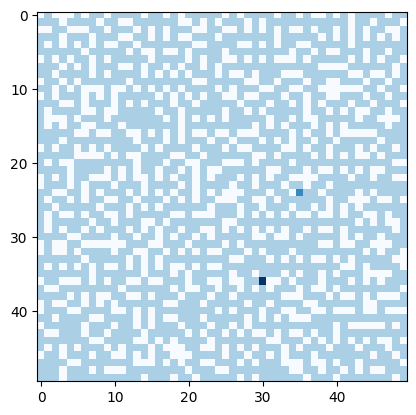

BOT LOCATION: (29, 26)
BUTTON LOCATION (36, 30)


In [16]:
# Generate Ship
D = 50 # ship size
q = 1   # flammability constant
seed = None

ship = Ship(D, q, seed)
ship.display()

test_bot = Bot(ship)
#print(test_bot.query_bot_1())
print("BOT LOCATION:", ship.bot_location)
print("BUTTON LOCATION", ship.button_location)


invalid path. querying bot again.
bot step: (30, 26)
(True, 11)


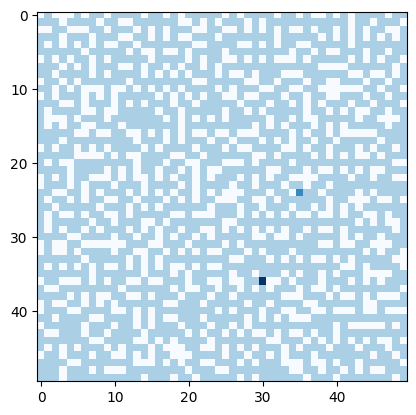

In [17]:
result = test_bot.simulate(test_bot.bot_3)
print(result[:2])
bot_path = result[2]
ship.display(bot_path)

In [18]:
# Data Analysis
import pandas as pd

D = 20

COLUMN_HEADERS = ["BOT", "RESULT", "STEPS", "SEED", "Q", "SIZE"]
SIZES = [25, 50, 75, 100, 150]
Q_VALS = [.1, .25, .5, .75, .9, .95]
NUM_Q = len(Q_VALS)
SHIPS = [Ship(D, None, Q_VALS[i]) for i in range(NUM_Q)]
NUM_SHIPS = len(SHIPS)

NUM_TRIALS = 100

trials = []

# Run every bot NUM_TRIALS times
"""for b in range(1, 5):
    for i in range(NUM_TRIALS):
        s_idx = i % NUM_SHIPS
        q_idx = i % NUM_Q
        seed = SEEDS[s_idx]
        ship = SHIPS[s_idx]
        q = Q_VALS[q_idx]

        bot = Bot(ship)

        bot_func = (
            bot.bot_one() if b == 1 else
            bot.bot_two() if b == 2 else
            bot.bot_three() if b == 3 else
            bot.bot_four()
        )  
        
        result, steps = bot.simulate(bot_func)
        trials.append((b + 1, result, steps, seed, q))"""

dummy_trials = [
    (random.randint(1, 5), random.choice([True, False]), random.randint(1, 100), None, random.choice(Q_VALS), random.choice(SIZES))
    for _ in range(500)
]

df = pd.DataFrame(columns = COLUMN_HEADERS, data = dummy_trials)
df

,BOT,RESULT,STEPS,SEED,Q,SIZE
0,4,True,95,None,0.75,100
1,1,False,19,None,0.90,100
2,4,False,81,None,0.90,75
3,5,True,2,None,0.50,150
4,5,True,70,None,0.25,100
...,...,...,...,...,...,...
495,5,False,25,None,0.75,25
496,2,True,74,None,0.25,150
497,2,False,71,None,0.50,25
498,1,False,47,None,0.95,25
